In [1]:
import numpy as np
import itertools

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('seaborn-poster')

In [3]:
import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

In [4]:

from MomentMatching.baseMomentMatch import MomentMatching, UnscentedTransform, TaylorTransform, MonteCarloTransform
from MomentMatching.TimeSeriesModel import TimeSeriesModel, UniformNonlinearGrowthModel, UniformNonlinearGrowthModel1
from MomentMatching.StateModels import GaussianState
from MomentMatching.ExpectationPropagation import EPNodes, TopEP
from Filters.KalmanFilter import KalmanFilterSmoother
from MomentMatching.newMomentMatch import UnscentedTransform as ut1


In [5]:
ut1(1)

In [6]:
np.random.seed(seed=102)

In [7]:
N = 20
system = UniformNonlinearGrowthModel1()
system1 = UniformNonlinearGrowthModel()
data = system.system_simulation(N)
x_true, x_noisy, y_true, y_noisy = zip(*data)

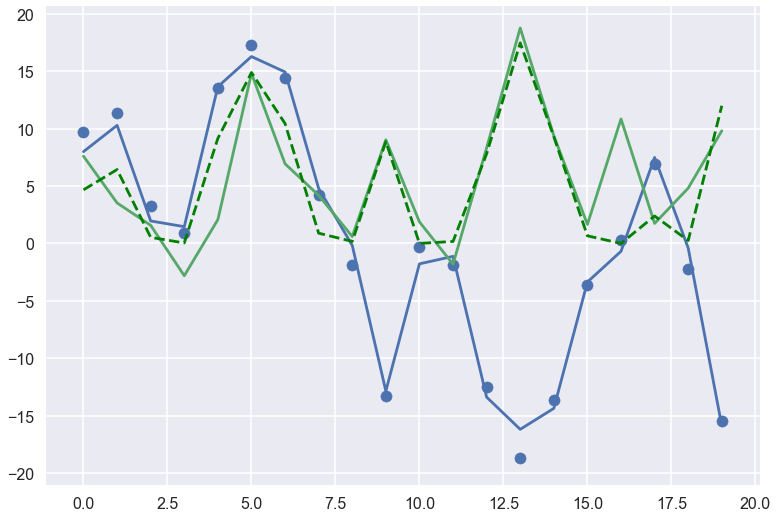

In [8]:
plt.plot(x_true)
plt.scatter(list(range(N)), x_noisy)
plt.plot(y_noisy)
plt.plot(y_true, 'g--')
plt.show()

In [9]:
# transform = TaylorTransform(dimension_of_state=1)
transform = UnscentedTransform(n=1)
transform1 = ut1(1)
# transform = MonteCarloTransform(dimension_of_state=1)
Nodes = EPNodes(dimension_of_state=1, N=N)

EP = TopEP(system_model=system, moment_matching=transform.moment_matching_KF)
kf = KalmanFilterSmoother(moment_matching=transform1, system_model=system1)

In [10]:
kf.kalman_filter(y_noisy, prior_state=system1.init_state)

[GaussianState 
  mean=
  [ 7.7257], 
  cov=
 [[ 55.2149]]), GaussianState 
  mean=
  [ 8.7653], 
  cov=
 [[ 11.3444]]), GaussianState 
  mean=
  [ 2.1051], 
  cov=
 [[ 1.6441]]), GaussianState 
  mean=
  [-0.7462], 
  cov=
 [[ 4.1257]]), GaussianState 
  mean=
  [ 1.7328], 
  cov=
 [[ 966.2752]]), GaussianState 
  mean=
  [ 2.4077], 
  cov=
 [[ 767.4248]]), GaussianState 
  mean=
  [ 1.1698], 
  cov=
 [[ 570.9566]]), GaussianState 
  mean=
  [-2.3341], 
  cov=
 [[ 777.1813]]), GaussianState 
  mean=
  [-1.417], 
  cov=
 [[ 551.5948]]), GaussianState 
  mean=
  [ 0.678], 
  cov=
 [[ 794.7731]]), GaussianState 
  mean=
  [ 0.7672], 
  cov=
 [[ 820.7293]]), GaussianState 
  mean=
  [ 0.4762], 
  cov=
 [[ 879.9947]]), GaussianState 
  mean=
  [-2.0572], 
  cov=
 [[ 636.5223]]), GaussianState 
  mean=
  [-3.6763], 
  cov=
 [[ 588.508]]), GaussianState 
  mean=
  [-1.8687], 
  cov=
 [[ 359.7908]]), GaussianState 
  mean=
  [ 2.2481], 
  cov=
 [[ 535.7882]]), GaussianState 
  mean=
  [ 2.713

In [ ]:
prior = Nodes[0].copy()
prior.marginal = system.init_dist

In [ ]:
system.init_dist

In [ ]:
# EP.forward_update(Nodes[0], prior, 0.0)

In [ ]:
def EP_update(self, Nodes, observations, fargs_list):
    prior = Nodes[0].copy()
    prior.marginal = self.system_model.init_dist
        # GaussianState(mean_vec=np.array([0.1]),
        #                            cov_matrix=0.1 * np.eye(1, dtype=float))
    node_iter, next_node_iter = itertools.tee(Nodes)
    next(next_node_iter, None)
    for node, next_node, obs, fargs in itertools.zip_longest(node_iter, next_node_iter, observations, fargs_list):
        pred_state = self.forward_update(node=node, prev_node=prior, fargs=fargs)
        corrected_state = self.measurement_update(pred_state, obs, fargs)
        
        if next_node is not None:
            smoothed_state = self.backward_update(corrected_state, next_node=next_node, fargs=fargs )
        else:
            smoothed_state = corrected_state
            
        yield smoothed_state
        prior = smoothed_state

In [ ]:
def kalman_filter(self, Nodes, observations, fargs_list):
    prior = Nodes[0].copy()
    prior.marginal = self.system_model.init_dist
        # GaussianState(mean_vec=np.array([0.1]),
        #                            cov_matrix=0.1 * np.eye(1, dtype=float))

    for node, obs, fargs in zip(Nodes, observations, fargs_list):
        pred_state = self.forward_update(node=node, prev_node=prior, fargs=fargs)
        corrected_state = self.measurement_update(pred_state, obs, fargs)
        yield corrected_state
        prior = corrected_state

        


In [ ]:
system.Q.cov

In [ ]:
ans = EP.kalman_filter( Nodes, y_noisy, range(0, N))

In [ ]:
# ans2 = EP_update(EP, Nodes, y_noisy, range(0, N))
# ep_data = list(ans2)

In [ ]:
x_filtered = list(ans)
x_filt_mean = [x.marginal.mean for x in x_filtered]

In [ ]:
plt.plot(x_filt_mean)
plt.plot(x_true, 'r--', label='x_true')

In [ ]:
def plot_gaussian(data):
    x_mean = np.array([x.marginal.mean for x in data])
    x_sigma = np.array([np.sqrt(x.marginal.cov[0, :]) for x in data])
    
    upr = x_mean + 2 * x_sigma
    lwr = x_mean - 2 * x_sigma
#     print(x_mean.shape)
#     print(upr.shape)
#     plt.plot(x_mean)
#     plt.plot(lwr)
#     plt.plot(upr)
#     ax.plt.figure()
    time = np.arange(len(data))
#     time = time[:, np.newaxis]
#     print(time.shape)
    plt.fill_between(time, lwr[:,0], upr[:,0], alpha=0.5)
    
#     print (x1)
#     print(x2)
#     print(x1 + 2 * x2)
#     print(x1 - 2 * x2)

In [ ]:
plot_gaussian(x_filtered)
plt.plot(x_true, 'r--', label='x_true')

In [ ]:
def kalman_smoother(self, Nodes, fargs_list):
    
    reversedNodes = reversed(Nodes)
    reveresedFargs = reversed(fargs_list)
    
    # Last filtered value is same as first smoothed
    next(reveresedFargs)
    next_node = next(reversedNodes)
    yield next_node
    
    for node, fargs in zip(reversedNodes, reveresedFargs):

        smoothed_node = self.backward_update(node=node, next_node=next_node, fargs=fargs)
#         print(f'node {node.t},  next_node {next_node.t}' )
        yield smoothed_node
        next_node = smoothed_node.copy()
        

In [ ]:
sms = kalman_smoother(EP, x_filtered, list(range(0, N)))
x_smoothed = (list(sms))

In [ ]:

x_smoothed_mean = [x.marginal.mean for x in reversed(x_smoothed)]

In [ ]:
[x.marginal.cov for x in reversed(x_smoothed)]

In [ ]:
plt.plot(x_true, 'r--', label='x_true')
plt.plot(x_filt_mean, 'b', label='x_filtered')
plt.plot(x_smoothed_mean, 'g', label='x_smoothed')


In [ ]:
plot_gaussian(x_filtered)
plot_gaussian(x_smoothed)
plt.plot(x_true, 'r--', label='x_true')

In [ ]:
data_list = list(reversed(x_smoothed))
for data in data_list:
    print(data.marginal.cov)

In [ ]:
ans = EP.kalman_filter(list(reversed(x_smoothed)), y_noisy, range(0, N))
x_filtered2 = list(ans)

In [ ]:
x_filt_mean2 = [x.marginal.mean for x in x_filtered2]

In [ ]:
plt.plot(x_true, 'r--', label='x_true')
plt.plot(x_filt_mean, 'b', label='x_filtered')
plt.plot(x_smoothed_mean, 'g', label='x_smoothed')
plt.plot(x_filt_mean2, 'b--', label='x_smthd_filt')